Load configs from yml files.
加载配置文件

In [1]:

import argparse
import ast
import copy
import os
import os.path as osp
from pprint import pformat

import numpy as np
import yaml


class Config:
    """
    Configuration namespace. Convert dictionary to members.
    """
    def __init__(self, cfg_dict):
        for k, v in cfg_dict.items():
            if isinstance(v, (list, tuple)):
                setattr(self, k, [Config(x) if isinstance(x, dict) else x for x in v])
            else:
                setattr(self, k, Config(v) if isinstance(v, dict) else v)

    def __str__(self):
        return pformat(self.__dict__)

    def __repr__(self):
        return self.__str__()


def parse_cli_to_yaml(parser, cfg, helper=None, choices=None, cfg_path="default_config.yaml"):
    """
    Parse command line arguments to the configuration according to the default yaml.

    Args:
        parser: Parent parser.
        cfg: Base configuration.
        helper: Helper description.
        cfg_path: Path to the default yaml config.
    """
    parser = argparse.ArgumentParser(description="[REPLACE THIS at config.py]",
                                     parents=[parser])
    helper = {} if helper is None else helper
    choices = {} if choices is None else choices
    for item in cfg:
        if not isinstance(cfg[item], list) and not isinstance(cfg[item], dict):
            help_description = helper[item] if item in helper else "Please reference to {}".format(cfg_path)
            choice = choices[item] if item in choices else None
            if isinstance(cfg[item], bool):
                parser.add_argument("--" + item, type=ast.literal_eval, default=cfg[item], choices=choice,
                                    help=help_description)
            else:
                parser.add_argument("--" + item, type=type(cfg[item]), default=cfg[item], choices=choice,
                                    help=help_description)
    args = parser.parse_args(args=[])
    return args


def parse_yaml(yaml_path):
    """
    Parse the yaml config file.

    Args:
        yaml_path: Path to the yaml config.
    """
    with open(yaml_path, 'r') as fin:
        try:
            cfgs = yaml.load_all(fin.read(), Loader=yaml.FullLoader)
            cfgs = [x for x in cfgs]
            if len(cfgs) == 1:
                cfg_helper = {}
                cfg = cfgs[0]
                cfg_choices = {}
            elif len(cfgs) == 2:
                cfg, cfg_helper = cfgs
                cfg_choices = {}
            elif len(cfgs) == 3:
                cfg, cfg_helper, cfg_choices = cfgs
            else:
                raise ValueError("At most 3 docs (config, description for help, choices) are supported in config yaml")
            print(cfg_helper)
        except:
            raise ValueError("Failed to parse yaml")
    return cfg, cfg_helper, cfg_choices


def merge(args, cfg):
    """
    Merge the base config from yaml file and command line arguments.

    Args:
        args: Command line arguments.
        cfg: Base configuration.
    """
    args_var = vars(args)
    for item in args_var:
        cfg[item] = args_var[item]
    return cfg


class Opts:
    """
    parameter configuration
    """
    def __init__(self, args=''):
        self.config = self.init(args)

    def parse(self, args=''):
        """parameter parse"""
        parser = argparse.ArgumentParser(description="default name", add_help=False)
        parser.add_argument("--config_path", type=str, default="./default_config.yaml",
                            help="Config file path")
        path_args, _ = parser.parse_known_args()
        default, helper, choices = parse_yaml(path_args.config_path)
        args = parse_cli_to_yaml(parser=parser, cfg=default, helper=helper, choices=choices,
                                 cfg_path=path_args.config_path)
        default = Config(merge(args, default))

        default.fix_res = not default.keep_res
        print('Fix size testing.' if default.fix_res else 'Keep resolution testing.')
        default.reg_offset = not default.not_reg_offset

        if default.head_conv == -1:  # init default head_conv
            default.head_conv = 256 if 'dla' in default.arch else 256
        default.pad = 31
        default.num_stacks = 1

        return default

    def update_dataset_info_and_set_heads(self, opt, dataset):
        """update dataset info and set heads"""
        input_h, input_w = dataset.default_resolution
        opt.mean, opt.std = dataset.mean, dataset.std
        opt.num_classes = dataset.num_classes

        # input_h(w): opt.input_h overrides opt.input_res overrides dataset default
        input_h = opt.input_res if opt.input_res > 0 else input_h
        input_w = opt.input_res if opt.input_res > 0 else input_w
        opt.input_h = opt.input_h if opt.input_h > 0 else input_h
        opt.input_w = opt.input_w if opt.input_w > 0 else input_w
        opt.output_h = opt.input_h // opt.down_ratio
        opt.output_w = opt.input_w // opt.down_ratio
        opt.input_res = max(opt.input_h, opt.input_w)
        opt.output_res = max(opt.output_h, opt.output_w)

        opt.heads = {'hm': opt.num_classes,
                     'wh': 2 if not opt.ltrb else 4,
                     'id': opt.reid_dim}
        if opt.reg_offset:
            opt.heads.update({'reg': 2})
        opt.nID = dataset.nID
        opt.img_size = (1088, 608)
        print('heads', opt.heads)
        return opt

    def init(self, args=''):
        """opt init"""
        default_dataset_info = {
            'mot': {'default_resolution': [608, 1088], 'num_classes': 1,
                    'mean': [0.408, 0.447, 0.470], 'std': [0.289, 0.274, 0.278],
                    'dataset': 'jde', 'nID': 14455},
        }

        class Struct:
            """opt struct"""
            def __init__(self, entries):
                for k, v in entries.items():
                    self.__setattr__(k, v)

        opt = self.parse(args)
        dataset = Struct(default_dataset_info['mot'])
        opt.dataset = dataset.dataset
        opt = self.update_dataset_info_and_set_heads(opt, dataset)
        return opt

    def get_config(self):
        return self.config


opt = Opts().get_config()
print(opt)

{}
Fix size testing.
heads {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}
{'K': 500,
 'arch': 'dla_34',
 'batch_size': 2,
 'cat_spec_wh': False,
 'conf_thres': 0.3,
 'config_path': './default_config.yaml',
 'data_cfg': './data/data.json',
 'data_dir': './test',
 'data_url': '',
 'dataset': 'jde',
 'dense_wh': False,
 'det_thres': 0.3,
 'device': 'Ascend',
 'down_ratio': 4,
 'fix_res': True,
 'head_conv': 256,
 'heads': {'hm': 1, 'id': 128, 'reg': 2, 'wh': 4},
 'hm_weight': 1,
 'id': 0,
 'id_loss': 'ce',
 'id_weight': 1,
 'img_size': (1088, 608),
 'input-video': '/videos/MOT16-03.mp4',
 'input_h': 608,
 'input_res': 1088,
 'input_video': '/videos/MOT16-03.mp4',
 'input_w': 1088,
 'is_modelarts': False,
 'keep_res': False,
 'load_model': './ckpt/Fairmot_0_1-30_5603.ckpt',
 'load_pre_model': './crowdhuman_dla34_ms.ckpt',
 'lr': 0.0001,
 'ltrb': True,
 'mean': [0.408, 0.447, 0.47],
 'min-box-area': 100,
 'min_box_area': 100,
 'mse_loss': False,
 'nID': 14455,
 'nms_thres': 0.4,
 'norm_wh': False,

Prepare dataset
准备数据集

In [2]:
import mindspore.dataset as ds
import collections
import random
import time
import math


def gaussian2D(shape, sigma=1):
    """gaussian2D"""
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h


def draw_umich_gaussian(heatmap, center, radius, k=1):
    """draw umich gaussian"""
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap



def draw_msra_gaussian(heatmap, center, sigma):
    """draw msra gaussian"""
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
        heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
        g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap


def gaussian_radius(det_size, min_overlap=0.7):
    """gaussian radius"""
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2
    return min(r1, r2, r3)



def letterbox(img, height=608, width=1088,
              color=(127.5, 127.5, 127.5)):
    """resize a rectangular image to a padded rectangular"""
    shape = img.shape[:2]  # shape = [height, width]
    ratio = min(float(height) / shape[0], float(width) / shape[1])
    new_shape = (round(shape[1] * ratio), round(shape[0] * ratio))  # new_shape = [width, height]
    dw = (width - new_shape[0]) / 2  # width padding
    dh = (height - new_shape[1]) / 2  # height padding
    top, bottom = round(dh - 0.1), round(dh + 0.1)
    left, right = round(dw - 0.1), round(dw + 0.1)
    img = cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)  # resized, no border
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # padded rectangular
    return img, ratio, dw, dh


def xyxy2xywh(x):
    # Convert bounding box format from [x1, y1, x2, y2] to [x, y, w, h]
    y = np.zeros(x.shape)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2
    y[:, 2] = x[:, 2] - x[:, 0]
    y[:, 3] = x[:, 3] - x[:, 1]
    return y

def random_affine(img, targets=None, degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-2, 2),
                  borderValue=(127.5, 127.5, 127.5)):
    """
    https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4
    """

    border = 0  # width of added border (optional)
    height = img.shape[0]
    width = img.shape[1]

    # Rotation and Scale
    R = np.eye(3)
    a = random.random() * (degrees[1] - degrees[0]) + degrees[0]
    # a += random.choice([-180, -90, 0, 90])  # 90deg rotations added to small rotations
    s = random.random() * (scale[1] - scale[0]) + scale[0]
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = (random.random() * 2 - 1) * translate[0] * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = (random.random() * 2 - 1) * translate[1] * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan((random.random() * (shear[1] - shear[0]) + shear[0]) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan((random.random() * (shear[1] - shear[0]) + shear[0]) * math.pi / 180)  # y shear (deg)

    M = np.matmul(S, np.matmul(T, R))  # Combined rotation matrix. ORDER IS IMPORTANT HERE!!
    imw = cv2.warpPerspective(img, M, dsize=(width, height), flags=cv2.INTER_LINEAR,
                              borderValue=borderValue)  # BGR order borderValue

    # Return warped points also
    if targets is not None:
        if np.shape(targets)[0] > 0:
            n = targets.shape[0]
            points = targets[:, 2:6].copy()
            area0 = (points[:, 2] - points[:, 0]) * (points[:, 3] - points[:, 1])

            # warp points
            xy = np.ones((n * 4, 3))
            xy[:, :2] = points[:, [0, 1, 2, 3, 0, 3, 2, 1]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = np.matmul(xy, M.T)[:, :2].reshape(n, 8)
            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # apply angle-based reduction
            radians = a * math.pi / 180
            reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
            x = (xy[:, 2] + xy[:, 0]) / 2
            y = (xy[:, 3] + xy[:, 1]) / 2
            w = (xy[:, 2] - xy[:, 0]) * reduction
            h = (xy[:, 3] - xy[:, 1]) * reduction
            xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

            # reject warped points outside of image
            # np.clip(xy[:, 0], 0, width, out=xy[:, 0])
            # np.clip(xy[:, 2], 0, width, out=xy[:, 2])
            # np.clip(xy[:, 1], 0, height, out=xy[:, 1])
            # np.clip(xy[:, 3], 0, height, out=xy[:, 3])
            w = xy[:, 2] - xy[:, 0]
            h = xy[:, 3] - xy[:, 1]
            area = w * h
            ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))
            i = (w > 4) & (h > 4) & (area / (area0 + 1e-16) > 0.1) & (ar < 10)

            targets = targets[i]
            targets[:, 2:6] = xy[i]

        return imw, targets, M
    return imw


class JointDataset:
    """ for training"""

    default_resolution = [1088, 608]
    mean = None
    std = None
    num_classes = 1

    def __init__(self, opt, root, paths, img_size=(1088, 608), augment=False):
        self.opt = opt
        self.img_files = collections.OrderedDict()
        self.label_files = collections.OrderedDict()
        self.tid_num = collections.OrderedDict()
        self.tid_start_index = collections.OrderedDict()
        self.num_classes = 1
        for ds, path in paths.items():
            path = osp.join(root, path)
            with open(path, 'r') as file:
                self.img_files[ds] = file.readlines()
                self.img_files[ds] = [osp.join(root, x.strip()) for x in self.img_files[ds]]
                self.img_files[ds] = list(filter(lambda x: len(x) > 0, self.img_files[ds]))
            self.label_files[ds] = [
                x.replace('images', 'labels_with_ids').replace('.png', '.txt').replace('.jpg', '.txt')
                for x in self.img_files[ds]]
        for ds, label_paths in self.label_files.items():
            max_index = -1
            for lp in label_paths:
                lb = np.loadtxt(lp)
                if np.shape(lb)[0] < 1:
                    continue
                if len(lb.shape) < 2:
                    img_max = lb[1]
                else:
                    img_max = np.max(lb[:, 1])
                if img_max > max_index:
                    max_index = img_max
            self.tid_num[ds] = max_index + 1
        last_index = 0
        for k, v in self.tid_num.items():
            self.tid_start_index[k] = last_index
            last_index += v
        self.nID = int(last_index + 1)  # 多个数据集中总的identity数目
        print('nID', self.nID)
        self.nds = [len(x) for x in self.img_files.values()]  # 图片数量
        print('nds', self.nds)
        self.cds = [sum(self.nds[:i]) for i in range(len(self.nds))]
        print('cds', self.cds)
        self.nF = sum(self.nds)
        self.width = img_size[0]
        self.height = img_size[1]
        self.max_objs = opt.K
        self.augment = augment

        print('=' * 80)
        print('dataset summary')
        print(self.tid_num)
        print('total # identities:', self.nID)
        print('start index')
        print(self.tid_start_index)
        print('=' * 80)

    def __getitem__(self, files_index):

        for i, c in enumerate(self.cds):
            if files_index >= c:
                ds = list(self.label_files.keys())[i]
                start_index = c

        img_path = self.img_files[ds][files_index - start_index]
        label_path = self.label_files[ds][files_index - start_index]
        imgs, labels, img_path = self.get_data(img_path, label_path)
        for i, _ in enumerate(labels):
            if labels[i, 1] > -1:
                labels[i, 1] += self.tid_start_index[ds]

        output_h = imgs.shape[1] // self.opt.down_ratio
        output_w = imgs.shape[2] // self.opt.down_ratio
        num_classes = self.num_classes
        num_objs = labels.shape[0]
        hm = np.zeros((num_classes, output_h, output_w), dtype=np.float32)
        if self.opt.ltrb:
            wh = np.zeros((self.max_objs, 4), dtype=np.float32)
        else:
            wh = np.zeros((self.max_objs, 2), dtype=np.float32)
        reg = np.zeros((self.max_objs, 2), dtype=np.float32)
        ind = np.zeros((self.max_objs,), dtype=np.int32)
        reg_mask = np.zeros((self.max_objs,), dtype=np.int32)
        ids = np.zeros((self.max_objs,), dtype=np.int32)
        bbox_xys = np.zeros((self.max_objs, 4), dtype=np.float32)

        draw_gaussian = draw_msra_gaussian if self.opt.mse_loss else draw_umich_gaussian
        for k in range(min(num_objs, self.max_objs)):
            label = labels[k]
            bbox = label[2:]
            cls_id = int(label[0])
            bbox[[0, 2]] = bbox[[0, 2]] * output_w
            bbox[[1, 3]] = bbox[[1, 3]] * output_h
            bbox_amodal = copy.deepcopy(bbox)
            bbox_amodal[0] = bbox_amodal[0] - bbox_amodal[2] / 2.
            bbox_amodal[1] = bbox_amodal[1] - bbox_amodal[3] / 2.
            bbox_amodal[2] = bbox_amodal[0] + bbox_amodal[2]
            bbox_amodal[3] = bbox_amodal[1] + bbox_amodal[3]
            bbox[0] = np.clip(bbox[0], 0, output_w - 1)
            bbox[1] = np.clip(bbox[1], 0, output_h - 1)
            h = bbox[3]
            w = bbox[2]

            bbox_xy = copy.deepcopy(bbox)
            bbox_xy[0] = bbox_xy[0] - bbox_xy[2] / 2
            bbox_xy[1] = bbox_xy[1] - bbox_xy[3] / 2
            bbox_xy[2] = bbox_xy[0] + bbox_xy[2]
            bbox_xy[3] = bbox_xy[1] + bbox_xy[3]

            if h > 0 and w > 0:
                radius = gaussian_radius((math.ceil(h), math.ceil(w)))
                radius = max(0, int(radius))
                radius = 6 if self.opt.mse_loss else radius
                # radius = max(1, int(radius)) if self.opt.mse_loss else radius
                ct = np.array(
                    [bbox[0], bbox[1]], dtype=np.float32)
                ct_int = ct.astype(np.int32)
                draw_gaussian(hm[cls_id], ct_int, radius)
                if self.opt.ltrb:
                    wh[k] = ct[0] - bbox_amodal[0], ct[1] - bbox_amodal[1], \
                            bbox_amodal[2] - ct[0], bbox_amodal[3] - ct[1]
                else:
                    wh[k] = 1. * w, 1. * h
                ind[k] = ct_int[1] * output_w + ct_int[0]
                reg[k] = ct - ct_int
                reg_mask[k] = 1
                ids[k] = label[1]
                bbox_xys[k] = bbox_xy
        # ret = {'input': imgs, 'hm': hm, 'reg_mask': reg_mask, 'ind': ind, 'wh': wh, 'reg': reg, 'ids': ids,
        # 'bbox': bbox_xys}
        return imgs, hm, reg_mask, ind, wh, reg, ids

    def __len__(self):
        return self.nF

    def get_data(self, img_path, label_path):
        """get data"""
        height = self.height
        width = self.width
        img = cv2.imread(img_path)  # BGR
        if img is None:
            raise ValueError('File corrupt {}'.format(img_path))
        augment_hsv = True
        if self.augment and augment_hsv:
            # SV augmentation by 50%
            fraction = 0.50
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            S = img_hsv[:, :, 1].astype(np.float32)
            V = img_hsv[:, :, 2].astype(np.float32)

            a = (random.random() * 2 - 1) * fraction + 1
            S *= a
            if a > 1:
                np.clip(S, a_min=0, a_max=255, out=S)

            a = (random.random() * 2 - 1) * fraction + 1
            V *= a
            if a > 1:
                np.clip(V, a_min=0, a_max=255, out=V)

            img_hsv[:, :, 1] = S.astype(np.uint8)
            img_hsv[:, :, 2] = V.astype(np.uint8)
            cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)
        h, w, _ = img.shape
        img, ratio, padw, padh = letterbox(img, height=height, width=width)
        # Load labels
        if os.path.isfile(label_path):
            labels0 = np.loadtxt(label_path, dtype=np.float32).reshape(-1, 6)

            # Normalized xywh to pixel xyxy format
            labels = labels0.copy()
            labels[:, 2] = ratio * w * (labels0[:, 2] - labels0[:, 4] / 2) + padw
            labels[:, 3] = ratio * h * (labels0[:, 3] - labels0[:, 5] / 2) + padh
            labels[:, 4] = ratio * w * (labels0[:, 2] + labels0[:, 4] / 2) + padw
            labels[:, 5] = ratio * h * (labels0[:, 3] + labels0[:, 5] / 2) + padh
        else:
            labels = np.array([])

        # Augment image and labels
        if self.augment:
            img, labels, _ = random_affine(img, labels, degrees=(-5, 5), translate=(0.10, 0.10), scale=(0.50, 1.20))

        plotFlag = False
        if plotFlag:
            import matplotlib
            matplotlib.use('Agg')
            import matplotlib.pyplot as plt
            plt.figure(figsize=(50, 50))
            plt.imshow(img[:, :, ::-1])
            plt.plot(labels[:, [1, 3, 3, 1, 1]].T, labels[:, [2, 2, 4, 4, 2]].T, '.-')
            plt.axis('off')
            plt.savefig('test.jpg')
            time.sleep(10)

        nL = len(labels)
        if nL > 0:
            # convert xyxy to xywh
            labels[:, 2:6] = xyxy2xywh(labels[:, 2:6].copy())  # / height
            labels[:, 2] /= width
            labels[:, 3] /= height
            labels[:, 4] /= width
            labels[:, 5] /= height
        if self.augment:
            # random left-right flip
            lr_flip = True
            if lr_flip & (random.random() > 0.5):
                img = np.fliplr(img)
                if nL > 0:
                    labels[:, 2] = 1 - labels[:, 2]

        img = np.ascontiguousarray(img[:, :, ::-1])  # BGR to RGB
        img = np.array(img, dtype=np.float32) / 255
        img = img.transpose((2, 0, 1))
        return img, labels, img_path


dataset_root = "./data"
train_set_paths = {
        "cuhksysu":"cuhksysu.train"
    }


dataset = JointDataset(opt, dataset_root, train_set_paths, (1088, 608), augment=True)


Ms_dataset = ds.GeneratorDataset(dataset, ['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'ids'],
                                         shuffle=True, num_parallel_workers=4,
                                         max_rowsize=8,
                                        )

Ms_dataset = Ms_dataset.batch(batch_size=4, drop_remainder=True)
batch_dataset_size = Ms_dataset.get_dataset_size()

nID 11932
nds [11206]
cds [0]
dataset summary
OrderedDict([('cuhksysu', 11931.0)])
total # identities: 11932
start index
OrderedDict([('cuhksysu', 0)])


Define model
定义神经网络模型

In [3]:
# Copyright 2020 Huawei Technologies Co., Ltd
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""
deep layer aggregation backbone
"""

import mindspore.ops as ops
import mindspore.nn as nn
from mindspore.common.initializer import Constant

BN_MOMENTUM = 0.1


class BasicBlock(nn.Cell):
    """
    Basic residual block for dla.

    Args:
        cin(int): Input channel.
        cout(int): Output channel.
        stride(int): Covolution stride. Default: 1.
        dilation(int): The dilation rate to be used for dilated convolution. Default: 1.

    Returns:
        Tensor, the feature after covolution.
    """

    def __init__(self, cin, cout, stride=1, dilation=1):
        super(BasicBlock, self).__init__()
        self.conv_bn_act = nn.Conv2dBnAct(cin, cout, kernel_size=3, stride=stride, pad_mode='pad',
                                          padding=dilation, has_bias=False, dilation=dilation,
                                          has_bn=True, momentum=BN_MOMENTUM,
                                          activation='relu', after_fake=False)
        self.conv_bn = nn.Conv2dBnAct(cout, cout, kernel_size=3, stride=1, pad_mode='same',
                                      has_bias=False, dilation=dilation, has_bn=True,
                                      momentum=BN_MOMENTUM, activation=None)
        self.relu = ops.ReLU()

    def construct(self, x, residual=None):
        """
        Basic residual block for dla.
        """
        if residual is None:
            residual = x

        out = self.conv_bn_act(x)
        out = self.conv_bn(out)
        out += residual
        out = self.relu(out)
        return out


class Root(nn.Cell):
    """
    Get HDA node which play as the root of tree in each stage

    Args:
        cin(int): Input channel.
        cout(int):Output channel.
        kernel_size(int): Covolution kernel size.
        residual(bool): Add residual or not.

    Returns:
        Tensor, HDA node after aggregation.
    """

    def __init__(self, in_channels, out_channels, kernel_size, residual):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1, stride=1, has_bias=False,
                              pad_mode='pad', padding=(kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(out_channels, momentum=BN_MOMENTUM)
        self.relu = ops.ReLU()
        self.residual = residual
        self.cat = ops.Concat(axis=1)

    def construct(self, x):
        """
        Get HDA node which play as the root of tree in each stage
        """
        children = x
        x = self.conv(self.cat(x))
        x = self.bn(x)
        if self.residual:
            x += children[0]
        x = self.relu(x)
        return x


class Tree(nn.Cell):
    """
    Construct the deep aggregation network through recurrent. Each stage can be seen as a tree with multiple children.

    Args:
        levels(list int): Tree height of each stage.
        block(Cell): Basic block of the tree.
        in_channels(list int): Input channel of each stage.
        out_channels(list int): Output channel of each stage.
        stride(int): Covolution stride. Default: 1.
        level_root(bool): Whether is the root of tree or not. Default: False.
        root_dim(int): Input channel of the root node. Default: 0.
        root_kernel_size(int): Covolution kernel size at the root. Default: 1.
        dilation(int): The dilation rate to be used for dilated convolution. Default: 1.
        root_residual(bool): Add residual or not. Default: False.

    Returns:
        Tensor, the root ida node.
    """

    def __init__(self, levels, block, in_channels, out_channels, stride=1, level_root=False,
                 root_dim=0, root_kernel_size=1, dilation=1, root_residual=False):
        super(Tree, self).__init__()
        self.levels = levels
        if root_dim == 0:
            root_dim = 2 * out_channels
        if level_root:
            root_dim += in_channels
        if self.levels == 1:
            self.tree1 = block(in_channels, out_channels, stride, dilation=dilation)
            self.tree2 = block(out_channels, out_channels, 1, dilation=dilation)
        else:
            self.tree1 = Tree(levels - 1, block, in_channels, out_channels, stride, root_dim=0,
                              root_kernel_size=root_kernel_size, dilation=dilation, root_residual=root_residual)
            self.tree2 = Tree(levels - 1, block, out_channels, out_channels, root_dim=root_dim + out_channels,
                              root_kernel_size=root_kernel_size, dilation=dilation, root_residual=root_residual)
        if self.levels == 1:
            self.root = Root(root_dim, out_channels, root_kernel_size, root_residual)
        self.level_root = level_root
        self.root_dim = root_dim
        self.downsample = None
        self.project = None
        if stride > 1:
            self.downsample = nn.MaxPool2d(stride, stride=stride)
        if in_channels != out_channels:
            self.project = nn.Conv2dBnAct(in_channels, out_channels, kernel_size=1, stride=1, pad_mode='same',
                                          has_bias=False, has_bn=True, momentum=BN_MOMENTUM,
                                          activation=None, after_fake=False)

    def construct(self, x, residual=None, children=None):
        """construct each stage tree recurrently"""
        children = () if children is None else children
        bottom = self.downsample(x) if self.downsample else x
        residual = self.project(bottom) if self.project else bottom
        if self.level_root:
            children += (bottom,)
        x1 = self.tree1(x, residual)
        if self.levels == 1:
            x2 = self.tree2(x1)
            ida_node = (x2, x1) + children
            x = self.root(ida_node)
        else:
            children += (x1,)
            x = self.tree2(x1, children=children)
        return x


class DLA34(nn.Cell):
    """
    Construct the downsampling deep aggregation network.

    Args:
        levels(list int): Tree height of each stage.
        channels(list int): Input channel of each stage
        block(Cell): Initial basic block. Default: BasicBlock.
        residual_root(bool): Add residual or not. Default: False

    Returns:
        tuple of Tensor, the root node of each stage.
    """

    def __init__(self, levels, channels, block=None, residual_root=False):
        super(DLA34, self).__init__()
        self.channels = channels
        self.base_layer = nn.Conv2dBnAct(3, channels[0], kernel_size=7, stride=1, pad_mode='same',
                                         has_bias=False, has_bn=True, momentum=BN_MOMENTUM,
                                         activation='relu', after_fake=False)
        self.level0 = self._make_conv_level(channels[0], channels[0], levels[0])
        self.level1 = self._make_conv_level(channels[0], channels[1], levels[1], stride=2)
        self.level2 = Tree(levels[2], block, channels[1], channels[2], 2,
                           level_root=False, root_residual=residual_root)
        self.level3 = Tree(levels[3], block, channels[2], channels[3], 2,
                           level_root=True, root_residual=residual_root)
        self.level4 = Tree(levels[4], block, channels[3], channels[4], 2,
                           level_root=True, root_residual=residual_root)
        self.level5 = Tree(levels[5], block, channels[4], channels[5], 2,
                           level_root=True, root_residual=residual_root)
        self.dla_fn = [self.level0, self.level1, self.level2, self.level3, self.level4, self.level5]

    def _make_conv_level(self, cin, cout, convs, stride=1, dilation=1):
        modules = []
        for i in range(convs):
            modules.append(nn.Conv2dBnAct(cin, cout, kernel_size=3, stride=stride if i == 0 else 1,
                                          pad_mode='pad', padding=dilation, has_bias=False, dilation=dilation,
                                          has_bn=True, momentum=BN_MOMENTUM, activation='relu', after_fake=False))
            cin = cout
        return nn.SequentialCell(modules)

    def construct(self, x):
        """
        Construct the downsampling deep aggregation network.
        """
        y = []
        x = self.base_layer(x)
        for i in range(len(self.channels)):
            x = self.dla_fn[i](x)
            y.append(x)
        return y


class DeformConv(nn.Cell):
    """
    Deformable convolution v2.

    Args:
        cin(int): Input channel
        cout(int): Output_channel

    Returns:
        Tensor, results after deformable convolution and activation
    """

    def __init__(self, cin, cout):
        super(DeformConv, self).__init__()
        self.actf = nn.SequentialCell([
            nn.BatchNorm2d(cout, momentum=BN_MOMENTUM),
            nn.ReLU()
        ])
        self.conv = nn.Conv2d(cin, cout, kernel_size=3, stride=1, has_bias=False)

    def construct(self, x):
        """
        Deformable convolution v2.
        """
        x = self.conv(x)
        x = self.actf(x)
        return x


class IDAUp(nn.Cell):
    """IDAUp sample."""

    def __init__(self, o, channels, up_f):
        super(IDAUp, self).__init__()
        proj_list = []
        up_list = []
        node_list = []
        for i in range(1, len(channels)):
            c = channels[i]
            f = int(up_f[i])
            proj = DeformConv(c, o)
            node = DeformConv(o, o)
            up = nn.Conv2dTranspose(o, o, f * 2, stride=f, pad_mode='pad', padding=f // 2, group=o)
            proj_list.append(proj)
            up_list.append(up)
            node_list.append(node)
        self.proj = nn.CellList(proj_list)
        self.up = nn.CellList(up_list)
        self.node = nn.CellList(node_list)

    def construct(self, layers, startp, endp):
        """IDAUp sample."""
        for i in range(startp + 1, endp):
            upsample = self.up[i - startp - 1]
            project = self.proj[i - startp - 1]
            layers[i] = upsample(project(layers[i].copy()))
            node = self.node[i - startp - 1]
            layers[i] = node(layers[i] + layers[i - 1])
        return layers


class DLAUp(nn.Cell):
    """DLAUp sample."""

    def __init__(self, startp, channels, scales, in_channels=None):
        super(DLAUp, self).__init__()
        self.startp = startp
        if in_channels is None:
            in_channels = channels
        self.channels = channels
        channels = list(channels)
        scales = np.array(scales, dtype=int)
        self.ida = []
        for i in range(len(channels) - 1):
            j = -i - 2
            self.ida.append(IDAUp(channels[j], in_channels[j:],
                                  scales[j:] // scales[j]))
            # setattr(self, 'ida_{}'.format(i),
            #         IDAUp(channels[j], in_channels[j:],
            #               scales[j:] // scales[j]))
            scales[j + 1:] = scales[j]
            in_channels[j + 1:] = [channels[j] for _ in channels[j + 1:]]
        self.ida_nfs = nn.CellList(self.ida)

    def construct(self, layers):
        """DLAUp sample."""
        out = [layers[-1]]  # start with 32
        for i in range(len(layers) - self.startp - 1):
            ida = self.ida_nfs[i]
            layers = ida(layers, len(layers) - i - 2, len(layers))
            out.append(layers[-1])
        a = []
        i = len(out)
        while i > 0:
            a.append(out[i - 1])
            i -= 1
        return a


class DLASegConv(nn.Cell):
    """
    The DLA backbone network.

    Args:
        down_ratio(int): The ratio of input and output resolution
        last_level(int): The ending stage of the final upsampling
        stage_levels(list int): The tree height of each stage block
        stage_channels(list int): The feature channel of each stage

    Returns:
        Tensor, the feature map extracted by dla network
    """

    def __init__(self, heads, down_ratio, final_kernel,
                 last_level, head_conv, out_channel=0, is_training=True):
        super(DLASegConv, self).__init__()
        assert down_ratio in [2, 4, 8, 16]
        self.first_level = int(np.log2(down_ratio))
        self.last_level = last_level
        self.is_training = is_training
        self.base = DLA34([1, 1, 1, 2, 2, 1], [16, 32, 64, 128, 256, 512], block=BasicBlock)
        channels = [16, 32, 64, 128, 256, 512]
        scales = [2 ** i for i in range(len(channels[self.first_level:]))]
        # self.dla_up = DLAUp(self.first_level, stage_channels[self.first_level:], last_level)
        self.dla_up = DLAUp(self.first_level, channels[self.first_level:], scales)
        if out_channel == 0:
            out_channel = channels[self.first_level]
        self.ida_up = IDAUp(out_channel, channels[self.first_level:self.last_level],
                            [2 ** i for i in range(self.last_level - self.first_level)])
        self.heads = heads
        for head in self.heads:
            classes = self.heads[head]
            if head_conv > 0:
                if 'hm' in head:
                    conv2d = nn.Conv2d(head_conv, classes, kernel_size=final_kernel, has_bias=True,
                                       bias_init=Constant(-2.19))
                    self.hm_fc = nn.SequentialCell(
                        [nn.Conv2d(channels[self.first_level], head_conv, kernel_size=3, has_bias=True), nn.ReLU(),
                         conv2d])
                elif 'wh' in head:
                    conv2d = nn.Conv2d(head_conv, classes, kernel_size=final_kernel, has_bias=True)
                    self.wh_fc = nn.SequentialCell(
                        [nn.Conv2d(channels[self.first_level], head_conv, kernel_size=3, has_bias=True), nn.ReLU(),
                         conv2d])
                elif 'id' in head:
                    conv2d = nn.Conv2d(head_conv, classes, kernel_size=final_kernel, has_bias=True)
                    self.id_fc = nn.SequentialCell(
                        [nn.Conv2d(channels[self.first_level], head_conv, kernel_size=3, has_bias=True), nn.ReLU(),
                         conv2d])
                else:
                    conv2d = nn.Conv2d(head_conv, classes, kernel_size=final_kernel, has_bias=True)
                    self.reg_fc = nn.SequentialCell(
                        [nn.Conv2d(channels[self.first_level], head_conv, kernel_size=3, has_bias=True), nn.ReLU(),
                         conv2d])
            else:
                if 'hm' in head:
                    self.hm_fc = nn.Conv2d(channels[self.first_level], classes, kernel_size=final_kernel, has_bias=True,
                                           bias_init=Constant(-2.19))
                elif 'wh' in head:
                    self.wh_fc = nn.Conv2d(channels[self.first_level], classes, kernel_size=final_kernel, has_bias=True)
                elif 'id' in head:
                    self.id_fc = nn.Conv2d(channels[self.first_level], classes, kernel_size=final_kernel, has_bias=True)
                else:
                    self.reg_fc = nn.Conv2d(channels[self.first_level], classes, kernel_size=final_kernel,
                                            has_bias=True)

    def construct(self, image):
        """The DLA backbone network."""
        x = self.base(image)
        x = self.dla_up(x)
        y = []
        for i in range(self.last_level - self.first_level):
            y.append(x[i].copy())
        y = self.ida_up(y, 0, len(y))
        hm = self.hm_fc(y[-1])
        wh = self.wh_fc(y[-1])
        feature_id = self.id_fc(y[-1])
        reg = self.reg_fc(y[-1])
        feature = {"hm": hm, "feature_id": feature_id, "wh": wh, "reg": reg}
        return feature



net = DLASegConv(opt.heads,
                     down_ratio=4,
                     final_kernel=1,
                     last_level=5,
                     head_conv=256)
net = net.set_train()
# param_dict = load_checkpoint(load_path)
# load_param_into_net(net, param_dict)



Define Loss and logger
定义损失函数然后开始训练

In [ ]:
import mindspore as ms
from mindspore.common.tensor import Tensor
from mindspore.common.parameter import Parameter
import cv2
# Copyright 2021 Huawei Technologies Co., Ltd
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""
Functional Cells to be used.
"""

import mindspore.nn as nn


class GatherFeature(nn.Cell):
    """
    Gather feature at specified position

    Args: None

    Returns:
        Tensor, feature at spectified position
    """

    def __init__(self):
        super(GatherFeature, self).__init__()
        self.tile = ops.Tile()
        self.shape = ops.Shape()
        self.concat = ops.Concat(axis=1)
        self.reshape = ops.Reshape()
        self.gather_nd = ops.GatherNd()

    def construct(self, feat, ind):
        """gather by specified index"""
        # (b, N)->(b*N, 1)
        b, N = self.shape(ind)
        ind = self.reshape(ind, (-1, 1))
        ind_b = nn.Range(0, b, 1)()
        ind_b = self.reshape(ind_b, (-1, 1))
        ind_b = self.tile(ind_b, (1, N))
        ind_b = self.reshape(ind_b, (-1, 1))
        index = self.concat((ind_b, ind))
        # (b, N, 2)
        index = self.reshape(index, (b, N, -1))
        # (b, N, c)
        feat = self.gather_nd(feat, index)
        return feat


class TransposeGatherFeature(nn.Cell):
    """
    Transpose and gather feature at specified position

    Args: None

    Returns:
        Tensor, feature at spectified position
    """

    def __init__(self):
        super(TransposeGatherFeature, self).__init__()
        self.shape = ops.Shape()
        self.reshape = ops.Reshape()
        self.transpose = ops.Transpose()
        self.perm_list = (0, 2, 3, 1)
        self.gather_feat = GatherFeature()

    def construct(self, feat, ind):
        """(b, c, h, w)->(b, h*w, c)"""
        feat = self.transpose(feat, self.perm_list)
        b, _, _, c = self.shape(feat)
        feat = self.reshape(feat, (b, -1, c))
        # (b, N, c)
        feat = self.gather_feat(feat, ind)
        return feat


class Sigmoid(nn.Cell):
    """
    Sigmoid and then Clip by value

    Args: None

    Returns:
        Tensor, feature after sigmoid and clip.
    """

    def __init__(self):
        super(Sigmoid, self).__init__()
        self.cast = ops.Cast()
        self.dtype = ops.DType()
        self.sigmoid = nn.Sigmoid()
        self.clip_by_value = ops.clip_by_value

    def construct(self, x, min_value=1e-4, max_value=1 - 1e-4):
        """Sigmoid and then Clip by value"""
        x = self.sigmoid(x)
        dt = self.dtype(x)
        x = self.clip_by_value(x, self.cast(ops.tuple_to_array((min_value,)), dt),
                               self.cast(ops.tuple_to_array((max_value,)), dt))
        return x




class FocalLoss(nn.Cell):
    """
    Warpper for focal loss.

    Args:
        alpha(int): Super parameter in focal loss to mimic loss weight. Default: 2.
        beta(int): Super parameter in focal loss to mimic imbalance between positive and negative samples. Default: 4.

    Returns:
        Tensor, focal loss.
    """

    def __init__(self, alpha=2, beta=4):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.pow = ops.Pow()
        self.log = ops.Log()
        self.select = ops.Select()
        self.equal = ops.Equal()
        self.less = ops.Less()
        self.cast = ops.Cast()
        self.fill = ops.Fill()
        self.dtype = ops.DType()
        self.shape = ops.Shape()
        self.reduce_sum = ops.ReduceSum()

    def construct(self, out, target):
        """focal loss"""
        pos_inds = self.cast(self.equal(target, 1.0), ms.float32)
        neg_inds = self.cast(self.less(target, 1.0), ms.float32)
        neg_weights = self.pow(1 - target, self.beta)

        pos_loss = self.log(out) * self.pow(1 - out, self.alpha) * pos_inds
        neg_loss = self.log(1 - out) * self.pow(out, self.alpha) * neg_weights * neg_inds

        num_pos = self.reduce_sum(pos_inds, ())
        num_pos = self.select(self.equal(num_pos, 0.0),
                              self.fill(self.dtype(num_pos), self.shape(num_pos), 1.0), num_pos)
        pos_loss = self.reduce_sum(pos_loss, ())
        neg_loss = self.reduce_sum(neg_loss, ())
        loss = - (pos_loss + neg_loss) / num_pos
        return loss


class RegLoss(nn.Cell):
    """
    Warpper for regression loss.

    Args:
        mode(str): L1 or Smoothed L1 loss. Default: "l1"

    Returns:
        Tensor, regression loss.
    """

    def __init__(self, mode='l1'):
        super(RegLoss, self).__init__()
        self.reduce_sum = ops.ReduceSum()
        self.cast = ops.Cast()
        self.expand_dims = ops.ExpandDims()
        self.reshape = ops.Reshape()
        self.gather_feature = TransposeGatherFeature()
        if mode == 'l1':
            self.loss = nn.L1Loss(reduction='sum')
        elif mode == 'sl1':
            self.loss = nn.SmoothL1Loss()
        else:
            self.loss = None

    def construct(self, output, mask, ind, target):
        """Warpper for regression loss."""
        pred = self.gather_feature(output, ind)
        mask = self.cast(mask, ms.float32)
        num = self.reduce_sum(mask, ())
        mask = self.expand_dims(mask, 2)
        target = target * mask
        pred = pred * mask
        regr_loss = self.loss(pred, target)
        regr_loss = regr_loss / (num + 1e-4)
        return regr_loss


class CenterNetMultiPoseLossCell(nn.Cell):
    """
    Provide pose estimation network losses.

    Args:
        net_config: The config info of CenterNet network.

    Returns:
        Tensor, total loss.
    """

    def __init__(self, opt):
        super(CenterNetMultiPoseLossCell, self).__init__()
        self.crit = FocalLoss()
        # self.crit_wh = RegWeightedL1Loss() if not config.net.dense_hp else nn.L1Loss(reduction='sum')
        self.crit_wh = RegLoss(opt.reg_loss)
        # wh
        self.crit_reg = RegLoss(opt.reg_loss)  # reg_loss = 'l1'
        self.hm_weight = opt.hm_weight  # hm_weight = 1 :loss weight for keypoint heatmaps
        self.wh_weight = opt.wh_weight  # wh_weight = 0.1 : loss weight for bounding box size
        self.off_weight = opt.off_weight  # off_weight = 1 : loss weight for keypoint local offsets
        self.reg_offset = opt.reg_offset  # reg_offset = True : regress local offset

        self.scalar_summary = ops.ScalarSummary()  # store losses scalars

        self.reg_ind = "reg" if self.reg_offset else "wh"

        # define id
        self.emb_dim = opt.reid_dim  # dataset.reid_dim = 128
        self.nID = opt.nID  # nId = 14455
        self.classifier = nn.Dense(self.emb_dim, self.nID).to_float(ms.float16)
        self.IDLoss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
        self.emb_scale = math.sqrt(2) * math.log(self.nID - 1)  # fix np
        self.s_det = Parameter(Tensor(-1.85 * np.ones(1), ms.float32))
        self.s_id = Parameter(Tensor(-1.05 * np.ones(1), ms.float32))

        self.normalize = ops.L2Normalize(axis=1)
        self.greater = ops.Greater()
        self.expand_dims = ops.ExpandDims()
        self.tile = ops.Tile()
        self.multiples_1 = (1, 1, 128)
        self.select = ops.Select()
        self.zeros = ops.Zeros()
        self.exp = ops.Exp()
        self.squeeze = ops.Squeeze(0)
        self.TransposeGatherFeature = TransposeGatherFeature()
        self.reshape = ops.Reshape()
        self.reshape_mul = opt.batch_size * opt.K
        self.cast = ops.Cast()
        self.sigmoid = Sigmoid()

    def construct(self, feature, hm, reg_mask, ind, wh, reg, ids):
        """Defines the computation performed."""
        output_hm = feature["hm"]  # FocalLoss()
        output_hm = self.sigmoid(output_hm)

        hm_loss = self.crit(output_hm, hm)
        self.scalar_summary("hm_loss", hm_loss)

        output_id = feature["feature_id"]  # SoftmaxCrossEntropyWithLogits()
        id_head = self.TransposeGatherFeature(output_id, ind)  # id_head=[1,500,128]

        # id_head = id_head[reg_mask > 0]
        cond = self.greater(reg_mask, 0)  # cond=[1,500]
        cond_cast = self.cast(cond, ms.int32)
        expand_output = self.expand_dims(cond_cast, 2)
        tile_out = self.tile(expand_output, self.multiples_1)
        tile_cast = self.cast(tile_out, ms.bool_)
        fill_zero = self.zeros(id_head.shape, ms.float32)  # fill_zero=[1,500,128]
        id_head = self.select(tile_cast, id_head, fill_zero)  # id_head=[1,500,128]

        id_head = self.emb_scale * self.normalize(id_head)  # id_head=[1,500,128]
        # id_head = self.emb_scale * ops.L2Normalize(id_head)

        zero_input = self.zeros(ids.shape, ms.int32)
        id_target = self.select(self.greater(ids, 0), ids, zero_input)  # id_target=[1,500]

        c_out = self.cast(id_head, ms.float16)
        id_output = self.classifier(c_out)  # id_output=[1,500,14455]
        id_output = self.cast(id_output, ms.float32)

        id_loss = self.IDLoss(id_output, id_target)
        self.scalar_summary("id_loss", id_loss)

        output_wh = feature["wh"]  # Regl1Loss
        wh_loss = self.crit_reg(output_wh, reg_mask, ind, wh)
        self.scalar_summary("wh_loss", wh_loss)

        off_loss = 0
        if self.reg_offset and self.off_weight > 0:  # Regl1Loss
            output_reg = feature[self.reg_ind]
            off_loss = self.crit_reg(output_reg, reg_mask, ind, reg)
        self.scalar_summary("off_loss", off_loss)

        det_loss = self.hm_weight * hm_loss + self.wh_weight * wh_loss + self.off_weight * off_loss
        self.scalar_summary("det_loss", det_loss)
        loss = self.exp(-self.s_det) * det_loss + self.exp(-self.s_id) * id_loss + (self.s_det + self.s_id)
        loss *= 0.5

        return loss


from mindspore import dtype as mstype

def dynamic_lr(num_epoch_per_decay, total_epochs, steps_per_epoch):
    """dynamic learning rate generator"""
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    decay_steps = steps_per_epoch * num_epoch_per_decay
    lr = nn.PolynomialDecayLR(1e-4, 1e-5, decay_steps, 0.5)
    for i in range(total_steps):
        if i < decay_steps:
            i = Tensor(i, mstype.int32)
            lr_each_step.append(lr(i).asnumpy())
        else:
            lr_each_step.append(1e-5)
    return lr_each_step



class WithLossCell(nn.Cell):
    """Cell with loss function.."""

    def __init__(self, net, loss):
        super(WithLossCell, self).__init__(auto_prefix=False)
        self._net = net
        self._loss = loss

    def construct(self, image, hm, reg_mask, ind, wh, reg, ids):
        """Cell with loss function."""
        feature = self._net(image)
        return self._loss(feature, hm, reg_mask, ind, wh, reg, ids)

    @property
    def backbone_network(self):
        """Return net."""
        return self._net


class WithNetCell(nn.Cell):
    """Cell with infer_net function.."""

    def __init__(self, net, infer_net):
        super(WithNetCell, self).__init__(auto_prefix=False)
        self._net = net
        self._infer_net = infer_net

    def construct(self, image):
        """Cell with loss function."""
        feature = self._net(image)
        return self._infer_net(feature)


from mindspore.train.callback import Callback

class LossCallback(Callback):
    """StopAtTime"""

    def __init__(self, bach_size):
        """init"""
        super(LossCallback, self).__init__()
        self.bach_size = bach_size
        self.time_start = time.time()

    def begin(self, run_context):
        """train begin"""
        cb_params = run_context.original_args()
        batch_num = cb_params.batch_num
        epoch_num = cb_params.epoch_num
        device_number = cb_params.device_number

        print("Starting Training : device_number={},per_step_size={},batch_size={}, epoch={}".format(device_number,
                                                                                                     batch_num,
                                                                                                     self.bach_size,
                                                                                                     epoch_num))

    def step_end(self, run_context):
        """step end"""
        cb_params = run_context.original_args()
        cur_epoch_num = cb_params.cur_epoch_num
        cur_step_num = cb_params.cur_step_num
        loss = cb_params.net_outputs[0].asnumpy()
        batch_num = cb_params.batch_num
        if cur_step_num > batch_num:
            cur_step_num = cur_step_num % batch_num + 1
        epoch_num = cb_params.epoch_num
        print("epoch: {}/{}, step: {}/{}, loss is {}".format(cur_epoch_num, epoch_num, cur_step_num, batch_num, loss))

    def end(self, run_context):
        """train end"""
        cb_params = run_context.original_args()
        device_number = cb_params.device_number
        time_end = time.time()
        seconds = time_end - self.time_start
        seconds = seconds % (24 * 3600)
        hour = seconds // 3600
        seconds %= 3600
        minutes = seconds // 60
        seconds %= 60
        print(device_number, "device totally cost:%02d:%02d:%02d" % (hour, minutes, seconds))


from mindspore.train.callback import TimeMonitor, ModelCheckpoint, CheckpointConfig
from mindspore.train.callback import SummaryCollector
from mindspore import Model

loss = CenterNetMultiPoseLossCell(opt)
lr = Tensor(dynamic_lr(20, opt.num_epochs, batch_dataset_size), mstype.float32)
optimizer = nn.Adam(net.trainable_params(), learning_rate=lr)
net_with_loss = WithLossCell(net, loss)
fairmot_net = nn.TrainOneStepCell(net_with_loss, optimizer)

    # define callback

summary_dir = './summary'
summary_cb = SummaryCollector(summary_dir, collect_freq=1)
loss_cb = LossCallback(opt.batch_size)
time_cb = TimeMonitor()
config_ckpt = CheckpointConfig(saved_network=net)

ckpoint_cb = ModelCheckpoint(prefix='Fairmot', directory='./ckpt/', config=config_ckpt)
callbacks = [loss_cb, ckpoint_cb, time_cb, summary_cb]

model = Model(fairmot_net)
# model.train(opt.num_epochs, Ms_dataset, callbacks=callbacks, dataset_sink_mode=True)


[WARNING] ME(24966:139931493070656,MainProcess):2022-10-31-12:52:33.696.498 [mindspore/train/model.py:1075] For LossCallback callback, {'begin', 'end', 'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


Starting Training : device_number=1,per_step_size=2801,batch_size=2, epoch=30


[WARNING] KERNEL(24966,7f4456eff740,python3.8):2022-10-31-12:52:57.777.156 [mindspore/ccsrc/plugin/device/gpu/kernel/gpu_kernel.cc:40] CheckDeviceSm] It is recommended to use devices with a computing capacity >= 7, but the current device's computing capacity is 6


Eval
载入训练好的模型做测试。

In [1]:
!pip install motmetrics
!pip install lap
!pip install cython_bbox

Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple


In [ ]:
import os
import logging
import os.path as osp
from mindspore import Tensor, context
from mindspore import dtype as mstype
from mindspore.train.serialization import load_checkpoint
import cv2
import motmetrics as mm
import numpy as np
from src.backbone_dla_conv import DLASegConv
from src.infer_net import InferNet
from src.config import Opts
from src.fairmot_pose import WithNetCell
from src.tracking_utils import visualization as vis
from src.tracker.multitracker import JDETracker
from src.tracking_utils.log import logger
from src.tracking_utils.utils import mkdir_if_missing
from src.tracking_utils.evaluation import Evaluator
from src.tracking_utils.timer import Timer
import src.utils.jde as datasets


def write_results(filename, results, data_type):
    """write eval results."""
    if data_type == 'mot':
        save_format = '{frame},{id},{x1},{y1},{w},{h},1,-1,-1,-1\n'
    elif data_type == 'kitti':
        save_format = '{frame} {id} pedestrian 0 0 -10 {x1} {y1} {x2} {y2} -10 -10 -10 -1000 -1000 -1000 -10\n'
    else:
        raise ValueError(data_type)

    with open(filename, 'w') as f:
        for frame_id, tlwhs, track_ids in results:
            if data_type == 'kitti':
                frame_id -= 1
            for tlwh, track_id in zip(tlwhs, track_ids):
                if track_id < 0:
                    continue
                x1, y1, w, h = tlwh
                x2, y2 = x1 + w, y1 + h
                line = save_format.format(frame=frame_id, id=track_id, x1=x1, y1=y1, x2=x2, y2=y2, w=w, h=h)
                f.write(line)
    logger.info('save results to %s', filename)


def eval_seq(opt, net, dataloader, data_type, result_filename, save_dir=None, show_image=True, frame_rate=30):
    """evaluation sequence."""
    if save_dir:
        mkdir_if_missing(save_dir)
    tracker = JDETracker(opt, frame_rate=frame_rate)
    timer = Timer()
    results = []
    frame_id = 0
    # for path, img, img0 in dataloader:
    for _, img, img0 in dataloader:
        if frame_id % 20 == 0:
            logger.info('Processing frame {} ({:.2f} fps)'.format(frame_id, 1. / max(1e-5, timer.average_time)))
        # run tracking
        timer.tic()
        blob = np.expand_dims(img, 0)
        blob = Tensor(blob, mstype.float32)
        img0 = Tensor(img0, mstype.float32)
        height, width = img0.shape[0], img0.shape[1]
        inp_height, inp_width = [blob.shape[2], blob.shape[3]]
        c = np.array([width / 2., height / 2.], dtype=np.float32)
        s = max(float(inp_width) / float(inp_height) * height, width) * 1.0
        meta = {'c': c, 's': s, 'out_height': inp_height // opt.down_ratio,
                'out_width': inp_width // opt.down_ratio}
        id_feature, dets = net(blob)
        online_targets = tracker.update(id_feature.asnumpy(), dets, meta)
        online_tlwhs = []
        online_ids = []
        for t in online_targets:
            tlwh = t.tlwh
            tid = t.track_id
            vertical = tlwh[2] / tlwh[3] > 1.6
            if tlwh[2] * tlwh[3] > opt.min_box_area and not vertical:
                online_tlwhs.append(tlwh)
                online_ids.append(tid)
        timer.toc()
        results.append((frame_id + 1, online_tlwhs, online_ids))
        if show_image or save_dir is not None:
            online_im = vis.plot_tracking(img0, online_tlwhs, online_ids, frame_id=frame_id,
                                          fps=1. / timer.average_time)
        if show_image:
            cv2.imshow('online_im', online_im)
        if save_dir is not None:
            cv2.imwrite(os.path.join(save_dir, '{:05d}.jpg'.format(frame_id)), online_im)
        frame_id += 1
    write_results(result_filename, results, data_type)
    return frame_id, timer.average_time, timer.calls


def main(opt, data_root, seqs=None, exp_name='MOT17_test_public_dla34',
         save_images=True, save_videos=False, show_image=False):
    """evaluation sequence."""
    logger.setLevel(logging.INFO)
    result_root = os.path.join(data_root, '..', 'results', exp_name)
    mkdir_if_missing(result_root)
    data_type = 'mot'
    # run tracking
    accs = []
    n_frame = 0
    timer_avgs, timer_calls = [], []
    backbone_net = DLASegConv(opt.heads,
                              down_ratio=4,
                              final_kernel=1,
                              last_level=5,
                              head_conv=256)
    load_checkpoint(opt.load_model, net=backbone_net)
    infer_net = InferNet()
    net = WithNetCell(backbone_net, infer_net)
    net.set_train(False)
    for sequence in seqs:
        output_dir = os.path.join(data_root, '..', 'outputs', exp_name, sequence) \
            if save_images or save_videos else None
        logger.info('start seq: %s', sequence)
        dataloader = datasets.LoadImages(osp.join(data_root, sequence, 'img1'), (1088, 608))
        result_filename = os.path.join(result_root, '{}.txt'.format(sequence))
        meta_info = open(os.path.join(data_root, sequence, 'seqinfo.ini')).read()
        frame_rate = int(meta_info[meta_info.find('frameRate') + 10:meta_info.find('\nseqLength')])
        nf, ta, tc = eval_seq(opt, net, dataloader, data_type, result_filename,
                              save_dir=output_dir, show_image=show_image, frame_rate=frame_rate)
        n_frame += nf
        timer_avgs.append(ta)
        timer_calls.append(tc)
        logger.info('Evaluate seq: %s', sequence)
        evaluator = Evaluator(data_root, sequence, data_type)
        accs.append(evaluator.eval_file(result_filename))
        if save_videos:
            print(output_dir)
            output_video_path = osp.join(output_dir, '{}.mp4'.format(sequence))
            cmd_str = 'ffmpeg -f image2 -i {}/%05d.jpg -c:v copy {}'.format(output_dir, output_video_path)
            os.system(cmd_str)
    timer_avgs = np.asarray(timer_avgs)
    timer_calls = np.asarray(timer_calls)
    all_time = np.dot(timer_avgs, timer_calls)
    avg_time = all_time / np.sum(timer_calls)
    logger.info('Time elapsed: {:.2f} seconds, FPS: {:.2f}'.format(all_time, 1.0 / avg_time))

    # get summary
    metrics = mm.metrics.motchallenge_metrics
    mh = mm.metrics.create()
    summary = Evaluator.get_summary(accs, seqs, metrics)
    strsummary = mm.io.render_summary(
        summary,
        formatters=mh.formatters,
        namemap=mm.io.motchallenge_metric_names
    )
    print(strsummary)
    Evaluator.save_summary(summary, os.path.join(result_root, 'summary_{}.xlsx'.format(exp_name)))


if __name__ == '__main__':
    opts = Opts().get_config()
    context.set_context(
        mode=context.GRAPH_MODE,
        device_target="CPU",
        save_graphs=False)
    seqs_str = '''MOT20-01
                  MOT20-02'''
    data_roots = opts.data_dir
    seq = [seq.strip() for seq in seqs_str.split()]
    main(opts,
         data_root=data_roots,
         seqs=seq,
         exp_name='MOT20_distribute_dla34_conv',
         show_image=False,
         save_images=True,
         save_videos=False)



{}
Fix size testing.
heads {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}


2022-11-08 16:55:46 [INFO]: start seq: MOT20-01
2022-11-08 16:55:46 [INFO]: Processing frame 0 (100000.00 fps)


Choose one of the output to visualize
选择输出图中的一帧可视化

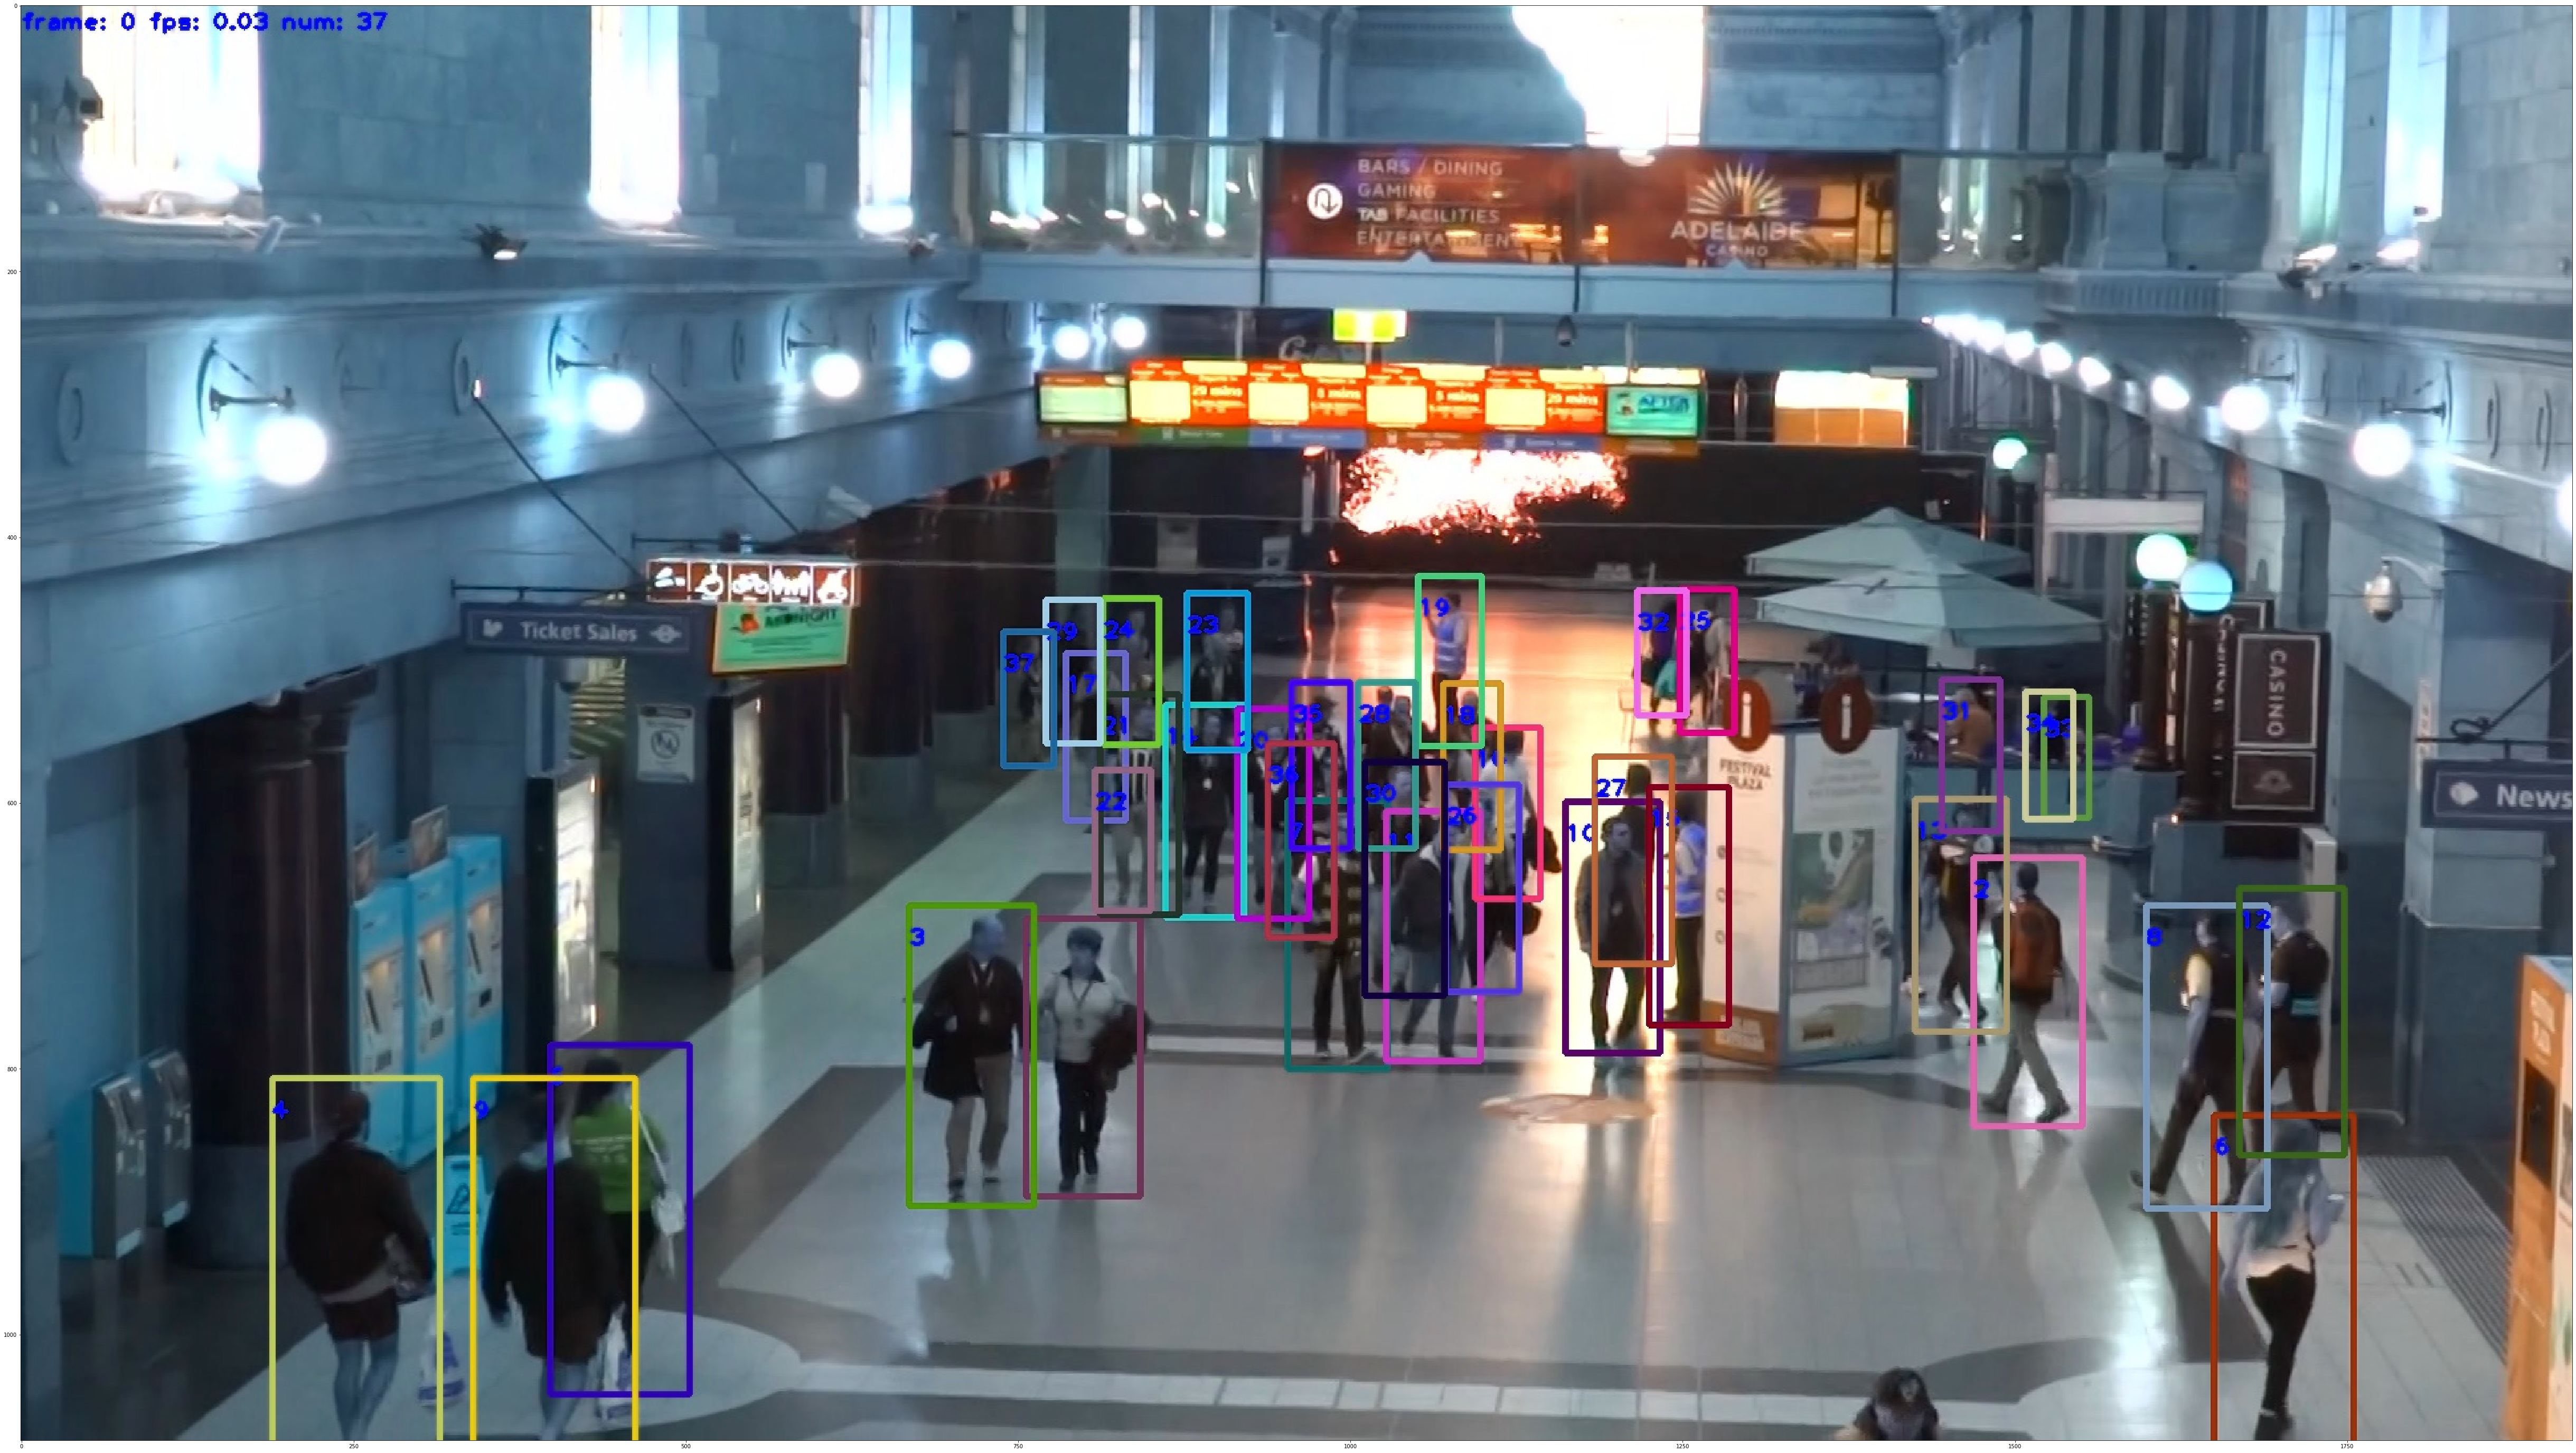

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [100, 50]
import glob
file = glob.glob("./outputs/MOT20_distribute_dla34_conv/*/*")[0]
img = cv2.imread(file)
plt.imshow(img)
plt.show()